# Fake News Detection with Data Visualization

In [3]:
pip install sklea

Note: you may need to restart the kernel to use updated packages.


In [3]:

import numpy as np
import pandas as pd
import re
import joblib
import spacy
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load NLP Models
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

stopwords = nlp.Defaults.stop_words
sentiment_analyzer = SentimentIntensityAnalyzer()


In [4]:
from tqdm import tqdm
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import logging
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
spacy.prefer_gpu()
# Basic logging configuration
logging.basicConfig(
    level=logging.INFO,  # Set the logging level to INFO
    format='%(asctime)s - %(processName)s - %(levelname)s - %(message)s'
)

# Create a logger instance
logger = logging.getLogger()

class TFIDFEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10000, n_components=300):
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features=self.max_features, stop_words="english", norm=None, use_idf=True,smooth_idf=True, sublinear_tf=False)
        self.svd = TruncatedSVD(n_components=self.n_components)

    def fit(self, X, y=None):
        print("🔍 Fitting TF-IDF Vectorizer...")
        tfidf_matrix = self.vectorizer.fit_transform(X)
        logger.info(" TF-IDF fitting complete. Starting SVD...")
        self.svd.fit(tfidf_matrix)
        logger.info("SVD fitting complete.")
        return self

    def transform(self, X):
        print("Transforming data using TF-IDF + SVD...")
        tfidf_matrix = self.vectorizer.transform(X)
        return self.svd.transform(tfidf_matrix)

class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.nlp is None:
            import spacy
            self.nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

        features = []
        print("🚀 Starting feature extraction...")

        for i, doc in enumerate(tqdm(self.nlp.pipe(X, batch_size=2048), total=len(X), desc=f"🔍 Processing Texts", position=0, leave=True)):
            if i % 500 == 0:
                logger.info(f"Processed {i}/{len(X)} texts...")
            pos_counts = {
                "nouns": sum(1 for token in doc if token.pos_ == "NOUN"),
                "verbs": sum(1 for token in doc if token.pos_ == "VERB"),
                "adjs": sum(1 for token in doc if token.pos_ == "ADJ"),
                "advs": sum(1 for token in doc if token.pos_ == "ADV"),
                "stopword_ratio": sum(1 for token in doc if token.is_stop) / (len(doc) + 1e-6),
                "avg_word_length": sum(len(token.text) for token in doc) / (len(doc) + 1e-6),
                "ner_person": sum(1 for ent in doc.ents if ent.label_ == "PERSON"),
                "ner_org": sum(1 for ent in doc.ents if ent.label_ == "ORG"),
                "ner_gpe": sum(1 for ent in doc.ents if ent.label_ == "GPE"),
                "sentiment": SentimentIntensityAnalyzer().polarity_scores(doc.text)['compound'],
            }
            features.append(list(pos_counts.values()))

        print("Feature extraction completed.")
        return np.array(features)


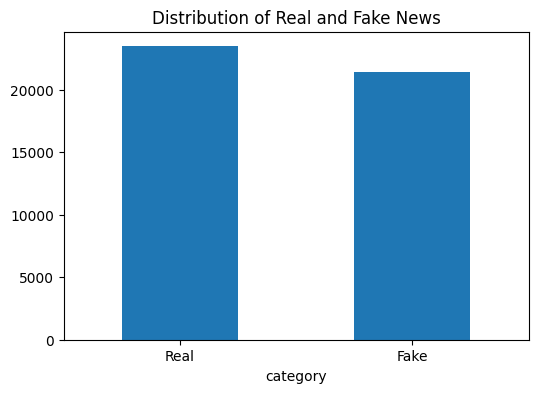

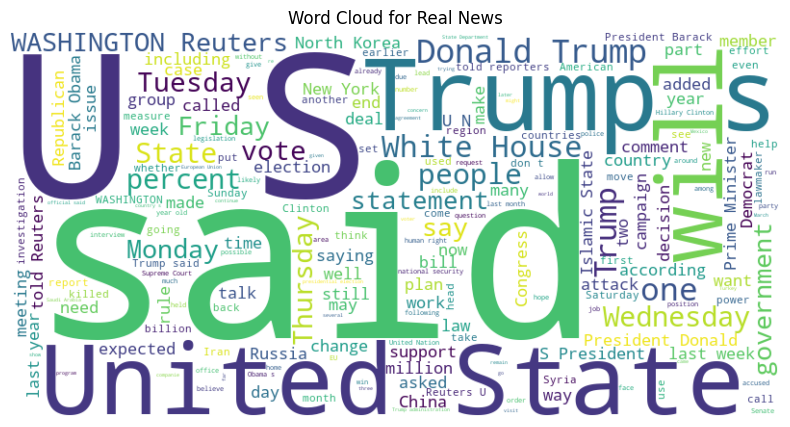

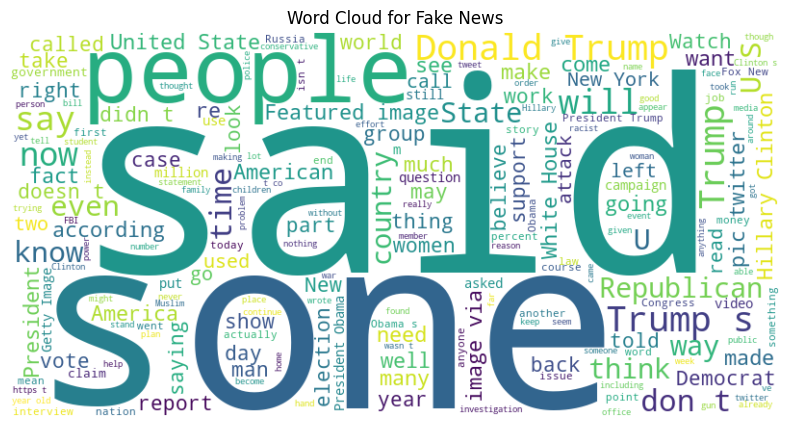

In [7]:

# Load & Preprocess Dataset
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")
real["category"] = 0
fake["category"] = 1
df = pd.concat([fake, real]).dropna(subset=["text"]).reset_index(drop=True)

# Data Visualization
plt.figure(figsize=(6, 4))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Real and Fake News')
plt.xticks(ticks=[0, 1], labels=['Real', 'Fake'], rotation=0)
plt.show()

# Word Clouds
for label, name in zip([0, 1], ["Real", "Fake"]):
    text = " ".join(df[df['category'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {name} News')
    plt.show()



Training: LinearSVC
Fitting 2 folds for each of 1 candidates, totalling 2 fits
🔍 Fitting TF-IDF Vectorizer...


2025-02-09 19:57:04,743 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 19:57:13,525 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:27<00:00, 19.35it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:13<00:00, 19.65it/s]


Feature extraction completed.
[CV 1/2] END ........................clf__C=0.1;, score=0.955 total time=31.3min
🔍 Fitting TF-IDF Vectorizer...


2025-02-09 20:28:22,086 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 20:28:34,417 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:17<00:00, 19.58it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:23<00:00, 19.46it/s]


Feature extraction completed.
[CV 2/2] END ........................clf__C=0.1;, score=0.955 total time=31.3min
🔍 Fitting TF-IDF Vectorizer...


2025-02-09 20:59:44,021 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 20:59:55,901 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 35918/35918 [30:43<00:00, 19.48it/s]


Feature extraction completed.
Training completed in 5642.73 seconds
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 8980/8980 [07:52<00:00, 18.99it/s]


Feature extraction completed.


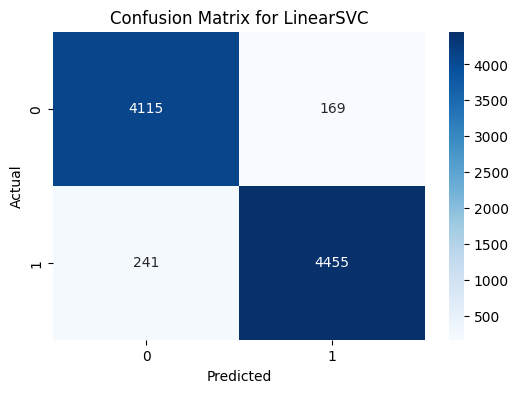

False Positives for LinearSVC: 169
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 1/1 [00:00<00:00, 100.06it/s]

Feature extraction completed.
Prediction for custom sentence ('Real' if 0, 'Fake' if 1): 1

Training: LogisticRegression
Fitting 2 folds for each of 1 candidates, totalling 2 fits


🔍 Fitting TF-IDF Vectorizer...


2025-02-09 21:39:06,145 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 21:39:14,931 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:52<00:00, 18.85it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [23:27<00:00, 12.76it/s]


Feature extraction completed.
[CV 1/2] END ........................clf__C=0.1;, score=0.956 total time=39.7min
🔍 Fitting TF-IDF Vectorizer...


2025-02-09 22:18:50,137 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 22:19:04,810 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:49<00:00, 18.92it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [57:30<00:00,  5.20it/s]


Feature extraction completed.
[CV 2/2] END ........................clf__C=0.1;, score=0.957 total time=73.8min
🔍 Fitting TF-IDF Vectorizer...


2025-02-09 23:32:44,937 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-09 23:33:08,042 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 35918/35918 [31:16<00:00, 19.15it/s]


Feature extraction completed.
Training completed in 8736.32 seconds
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 8980/8980 [07:57<00:00, 18.79it/s]


Feature extraction completed.


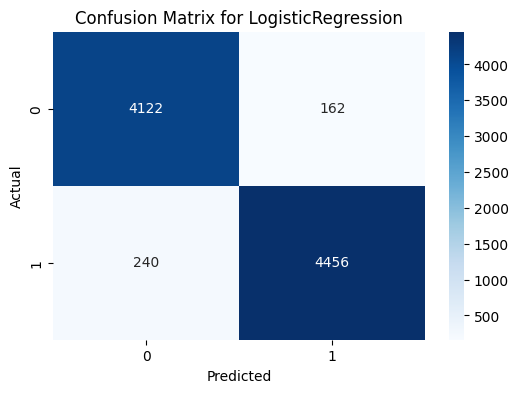

False Positives for LogisticRegression: 162
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 1/1 [00:00<00:00, 96.58it/s]

Feature extraction completed.
Prediction for custom sentence ('Real' if 0, 'Fake' if 1): 1

Training: MultinomialNB
Fitting 2 folds for each of 1 candidates, totalling 2 fits


🔍 Fitting TF-IDF Vectorizer...


2025-02-10 00:12:46,587 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-10 00:12:54,882 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:53<00:00, 18.83it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:42<00:00, 19.05it/s]


Feature extraction completed.
[CV 1/2] END ....................clf__alpha=0.1;, score=0.885 total time=32.0min
🔍 Fitting TF-IDF Vectorizer...


2025-02-10 00:44:44,466 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-10 00:44:54,727 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:52<00:00, 18.86it/s]


Feature extraction completed.
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 17959/17959 [15:43<00:00, 19.03it/s]


Feature extraction completed.
[CV 2/2] END ....................clf__alpha=0.1;, score=0.901 total time=32.0min
🔍 Fitting TF-IDF Vectorizer...


2025-02-10 01:16:46,519 - MainProcess - INFO -  TF-IDF fitting complete. Starting SVD...
2025-02-10 01:17:03,875 - MainProcess - INFO - SVD fitting complete.


Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 35918/35918 [37:15<00:00, 16.07it/s]


Feature extraction completed.
Training completed in 6104.63 seconds
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 8980/8980 [34:30<00:00,  4.34it/s]


Feature extraction completed.


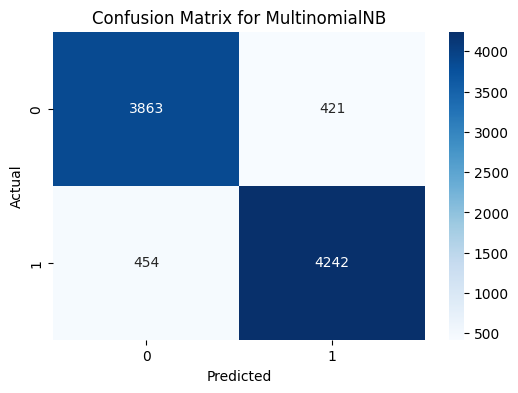

False Positives for MultinomialNB: 421
Transforming data using TF-IDF + SVD...
🚀 Starting feature extraction...


🔍 Processing Texts: 100%|██████████| 1/1 [00:00<00:00, 99.37it/s]

Feature extraction completed.
Prediction for custom sentence ('Real' if 0, 'Fake' if 1): 0

=== LinearSVC ===
Accuracy: 0.9543
F1 (Macro): 0.9543
F1 (Weighted): 0.9544
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4284
           1       0.96      0.95      0.96      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

False Positives: 169

=== LogisticRegression ===
Accuracy: 0.9552
F1 (Macro): 0.9552
F1 (Weighted): 0.9552
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4284
           1       0.96      0.95      0.96      4696

    accuracy                           0.96      8980
   macro avg       0.95      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

False Positives: 162

===

In [10]:
import numpy as np
import pandas as pd
import time
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming TFIDFEmbedder and TextFeatureExtractor are defined elsewhere

# Class Weights
class_weights = compute_class_weight("balanced", classes=np.unique(df["category"]), y=df["category"])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

def clip_negatives(X):
    return np.maximum(X, 0)

clipper = FunctionTransformer(clip_negatives, validate=False)

# Preprocessing & Splitting
X = df["text"]
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define Models
candidate_models = {
    "LinearSVC": (LinearSVC(dual=False, max_iter=3000, class_weight=class_weight_dict), {"clf__C": [0.1, 1, 10]}),
    "LogisticRegression": (LogisticRegression(solver="liblinear", max_iter=3000, class_weight=class_weight_dict), {"clf__C": [0.1, 1, 10]}),
    "MultinomialNB": (MultinomialNB(), {"clf__alpha": [0.01, 0.1, 1, 10]})
}

# Training & Model Selection
custom_sentence = "The stock market witnessed a significant surge as major companies reported strong earnings this quarter."
results = {}

for model_name, (clf_instance, param_dist) in candidate_models.items():
    print(f"\nTraining: {model_name}")

    pipeline = Pipeline([
        ("text_features", FeatureUnion([
            ("tfidf_embedder", TFIDFEmbedder(max_features=10000, n_components=300)),
            ("extra_features", TextFeatureExtractor())
        ])),
        ("clipper", clipper),  # Clip negative values to zero
        ("clf", clf_instance)
    ])

    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=1, cv=2,
        verbose=3, n_jobs=1, random_state=42, scoring='f1'
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    print(f"Training completed in {time.time() - start_time:.2f} seconds")

    y_pred = random_search.best_estimator_.predict(X_test)

    # Calculate F1 Scores
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # False Positives
    false_positives = ((y_test == 0) & (y_pred == 1)).sum()
    print(f"False Positives for {model_name}: {false_positives}")

    results[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": cm,
        "false_positives": false_positives
    }

    joblib.dump(random_search.best_estimator_, f"best_model_{model_name}.pkl")
    prediction = random_search.best_estimator_.predict([custom_sentence])[0]
    print(f"Prediction for custom sentence ('Real' if 0, 'Fake' if 1): {prediction}")

# Display Results
for model, metrics in results.items():
    print(f"\n=== {model} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 (Weighted): {metrics['f1_weighted']:.4f}")
    print("Classification Report:")
    print(metrics['classification_report'])
    print(f"False Positives: {metrics['false_positives']}")
